# Stock Price Indicator
                
## Project aims to predict adjusted close price of some stocks chosen previously.


## 1- Data Exploration
### A- get historical values
### B- plot Adjusted Close column
### C- check for null values


In [1]:
#A- get historical values

import pandas as pd
import pandas_datareader as pdr
import datetime

adjclose = 'Adj Close'

stock_list = ['AAPL', 'AMZN', 'AVGO', 'CSCO', 'MA', 'MSFT', 'NVDA', 'NVS', 'PFE', 'QCOM', 'TXN', 'V', 'WMT']

start=datetime.datetime(2010,3,20)

end=datetime.datetime(2019,3,19)

#for stock in stock_list:
    #history = pdr.get_data_yahoo(stock, start, end)
    #history.to_csv('./data1/'+stock+'.csv')

AMZN = pd.read_csv('data/AMZN.csv', header=0, parse_dates=['Date'])
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-03-22,130.960007,128.639999,130.199997,130.470001,5383400,130.470001
1,2010-03-23,130.940002,128.070007,130.889999,129.259995,4213100,129.259995
2,2010-03-24,129.399994,127.199997,128.639999,128.039993,4696400,128.039993
3,2010-03-25,136.910004,128.039993,129.139999,134.729996,16209600,134.729996
4,2010-03-26,136.990005,133.759995,134.899994,135.059998,6565700,135.059998


In [2]:
# B- plot Adjusted Close column

import datetime
import matplotlib as plt

stock_data_list = []

for stock in stock_list:
    stock_data = pd.read_csv('data/'+stock+'.csv', header=0, parse_dates=['Date'])
    stock_data.set_index('Date',inplace=True)
    plott = stock_data[adjclose].plot(figsize=(16, 12), label=stock)
    plott.legend()
    stock_data['stock_name'] = stock
    stock_data_list.append(stock_data)



In [3]:
# C- check for null values

for stock_data in stock_data_list:
    print(stock_data.isnull().any().any())

False
False
False
False
False
False
False
False
False
False
False
False
False


## 2- Domain Research
### A- Add Key Feature Columns to Data
### B- Plot Examples for Key Features

In [4]:
#A- Add Key Feature Columns to Data
import numpy as np
#Add MACD 26, 12 day periods
def add_MACD(dataframe):
    macd26 = dataframe[adjclose].ewm(span=26, min_periods=26, adjust= True).mean()
    macd12 = dataframe[adjclose].ewm(span=12, min_periods=12, adjust= True).mean()
    dataframe["MACD"] = macd26-macd12
    return dataframe

#Add RSI Wilder's RSI
def add_RSI(df, column=adjclose, period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    return df.join(rsi.to_frame('RSI'))

#Add Bollinger Bands
def add_BollingerBand(df, column=adjclose, period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

def get_weighted_average(dataframe,window,columnname_data,columnname_weights):
    processed_dataframe=dataframe.loc[:,(columnname_data,columnname_weights)].set_index(columnname_weights)   
    def get_mean_withweights(processed_dataframe_windowed):
        return np.average(a=processed_dataframe_windowed,weights=processed_dataframe_windowed.index)
    tmp_df = processed_dataframe.rolling(window=window).apply(func=get_mean_withweights,raw=False)
    tmp_df = tmp_df.reset_index()
    dataframe = dataframe.reset_index()
    tmp_df2 = dataframe.join(tmp_df[adjclose].to_frame('WMA'))
    tmp_df2.set_index('Date',inplace=True)
    #print(tmp_df2)
    return tmp_df2


for index, stock_data in enumerate(stock_data_list):
    stock_data = add_MACD(stock_data)
    stock_data = add_RSI(stock_data)
    stock_data = add_BollingerBand(stock_data)
    stock_data = get_weighted_average(stock_data,10,adjclose, 'Volume')
    #print(stock_data.columns)
    #print(stock_data)
    #stock_data['MACD'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['RSI'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDUP'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDLO'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['WMA'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    stock_data = stock_data[25:] #delete NaN values
    stock_data_list[index] = stock_data

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'stock_name',
       'MACD', 'RSI', 'BBANDUP', 'BBANDLO', 'WMA'],
      dtype='object')


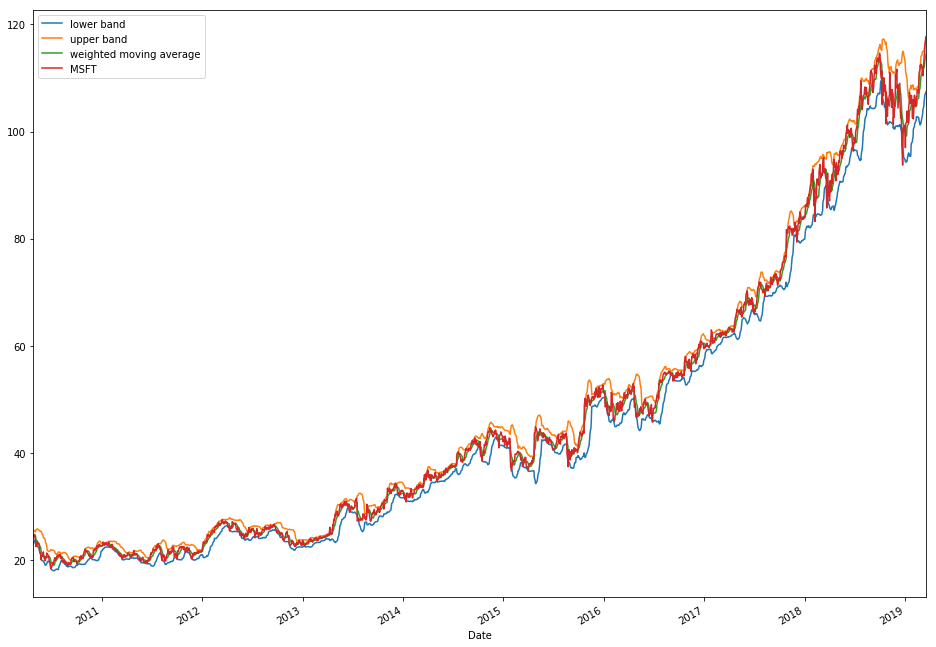

In [5]:
def plot_stock(index):
    stock_data = stock_data_list[index]
    print(stock_data.columns)

    #plot Bollinger Bands
    plt1 = stock_data['BBANDLO'].plot(figsize=(16, 12), label='lower band')
    stock_data['BBANDUP'].plot(label='upper band')
    stock_data['WMA'].plot(label='weighted moving average')
    stock_data[adjclose].plot(label=stock_data['stock_name'][0])
    plt1.legend()
    
plot_stock(5)



#plot RSI and MACD
#plot2 =  stock_data['RSI'].plot(figsize=(16, 12), label='RSI')

## 2- Data Normalization & Seperation

In [6]:
from sklearn import preprocessing

normalized_stock_list = []
y_adj_close_list = []
scaler = preprocessing.MinMaxScaler()


for stock_data in stock_data_list:
    stock_data = stock_data.drop(columns='stock_name')
   
    names = stock_data.columns
    scaled_df = scaler.fit_transform(stock_data)
    scaled_df = pd.DataFrame(scaled_df, columns=names)
    #scale adjusted price to 100
    scaled_df[adjclose] = scaled_df[adjclose].apply(lambda x: x*100)

    
    y_adj_close_list.append(scaled_df[adjclose])
    scaled_df = scaled_df.drop(columns=adjclose)
    
    normalized_stock_list.append(scaled_df)

#since we want n+1 adj close price to be predicted with the n th day values
#we need to shift y values for 1 day 
for y_adj_close in y_adj_close_list:
    y_adj_close.shift(-1)




    
print(y_adj_close_list[5]) # our target list to predict  
print(normalized_stock_list[5]) # our input values for models  
   


0         6.232732
1         6.281071
2         6.353582
3         5.982979
4         6.240790
5         5.652660
6         5.427072
7         4.726149
8         4.105787
9         4.693921
10        4.645576
11        5.096754
12        4.935621
13        4.685865
14        4.693921
15        4.523967
16        4.232612
17        3.318116
18        3.099600
19        2.638310
20        2.476448
21        1.618589
22        2.419793
23        2.257935
24        2.330771
25        2.792076
26        3.115788
27        2.249843
28        1.845195
29        1.699525
           ...    
2209     89.024115
2210     87.829382
2211     87.066355
2212     87.467954
2213     87.046286
2214     88.692802
2215     88.612478
2216     88.702841
2217     90.028084
2218     89.977883
2219     89.413259
2220     91.691931
2221     93.264816
2222     93.889933
2223     94.666298
2224     94.474726
2225     94.333570
2226     94.837701
2227     94.565474
2228     94.000842
2229     94.051258
2230     92.

/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3- Building:
### A: Benchmark Model
### B: RMSE and R2 Validation
### C: Solution Model
### D: Test Flow


In [7]:
# A- For Benchmark we will use standard linear regression
from keras.layers import Dense
from keras.models import Model, Sequential
from keras import initializers, optimizers
from sklearn.model_selection import train_test_split

from pylab import *


def create_benchmark_model():
   model = Sequential()
   model.add(Dense(1, activation = 'linear', input_dim = 10))
   sgd = optimizers.SGD(lr=0.2)
   model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['accuracy'])
   return model

# B - RMSE Score, R2 Score
from sklearn.metrics import mean_squared_error, r2_score


def RMSE_score(y, y_predicted, method_name):
    RMSE_score = np.sqrt(mean_squared_error(y, y_predicted))
    print(method_name + " RMSE Score: {0}".format(RMSE_score))
    return RMSE_score


def R2_score(y, y_predicted, method_name):
    R2_score = r2_score(y, y_predicted)
    print( method_name +" R2 Score: {0}".format(R2_score))
    return R2_score

def check_score(y, y_predicted, method_name):
    rmse = RMSE_score(y, y_predicted, method_name)
    r2 = R2_score(y, y_predicted, method_name)
    return rmse, r2


Using TensorFlow backend.


In [12]:
# C - Solution Models LSTM and SVM 
from sklearn import svm
from keras.layers.recurrent import LSTM
from keras.layers import Dropout, Activation, Flatten
import numpy 

def create_svm_linear_model():
    model = svm.SVR(kernel='linear', C=100)
    return model

def create_svm_polynomial_model():
    model = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
    return model

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(return_sequences=True, input_shape=(1, 10), units=100, dropout=0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model
       

In [13]:
#D -Test Flow

def drive_test(use_different_models):
    results_dataframe = pd.DataFrame()
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        if(index > 3): break
        #create models
        if (use_different_models or index == 0):
            linear_regression_model = create_benchmark_model() 
            svm_linear = create_svm_linear_model()
            svm_polynomial = create_svm_polynomial_model()
            lstm_model = create_lstm_model()
        linear_regression_model = create_benchmark_model() 
        svm_linear = create_svm_linear_model()
        svm_polynomial = create_svm_polynomial_model()
        lstm_model = create_lstm_model()
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                        y_adj_close_list[index], test_size=0.20, random_state=42)

        linear_regression_model.fit(X_train, y_train, epochs =100,batch_size = 32)
        linear_y_predict = linear_regression_model.predict(X_test)


        svm_linear.fit(X_train, y_train)
        svm_linear_y_predict = svm_linear.predict(X_test)


        svm_polynomial.fit(X_train, y_train)
        svm_polynomial_y_predict = svm_polynomial.predict(X_test)

        trainX = numpy.reshape(X_train.values, (X_train.shape[0],1, -1))
        testX = numpy.reshape(X_test.values, (X_test.shape[0],1, X_test.shape[1]))
        lstm_model.fit(trainX, y_train, batch_size =32,epochs = 1000)
        lstm_y_predict = lstm_model.predict(testX)

        rmse_1, r2_1 = check_score(y_test, linear_y_predict, "Linear Regression")
        rmse_2, r2_2 = check_score(y_test, svm_linear_y_predict, "SVM Linear Model")
        rmse_3, r2_3 = check_score(y_test, svm_polynomial_y_predict, "SVM Polynomial Model")
        rmse_4, r2_4 = check_score(y_test, lstm_y_predict, "LSTM Model")

        print(index )

        df = pd.DataFrame({"linear_rmse": rmse_1,  "linear_r2": r2_1, 
                                   "svm_linear_rmse":rmse_2, "svm_linear_r2":r2_2,
                                   "svm_polynomial_rmse":rmse_3, "svm_polynomial_r2":r2_3,
                                   "lstm_rmse":rmse_4, "lstm_r2":r2_4 }, index=[index])

        results_dataframe = results_dataframe.append(df)
    return results_dataframe

In [14]:
results_different_models = drive_test(True)
#result_same_models = drive_test(False)

Epoch 1/100
1791/1791 [==============================] - 0s 163us/step - loss: 43.9955 - acc: 0.0000e+00
Epoch 2/100
1791/1791 [==============================] - 0s 12us/step - loss: 2.0144 - acc: 5.5835e-04
Epoch 3/100
1791/1791 [==============================] - 0s 12us/step - loss: 1.9527 - acc: 5.5835e-04
Epoch 4/100
1791/1791 [==============================] - 0s 12us/step - loss: 1.8967 - acc: 0.0000e+00
Epoch 5/100
1791/1791 [==============================] - 0s 11us/step - loss: 1.8582 - acc: 0.0000e+00
Epoch 6/100
1791/1791 [==============================] - 0s 11us/step - loss: 1.7768 - acc: 5.5835e-04
Epoch 7/100
1791/1791 [==============================] - 0s 12us/step - loss: 1.7800 - acc: 0.0000e+00
Epoch 8/100
1791/1791 [==============================] - 0s 13us/step - loss: 1.6914 - acc: 0.0000e+00
Epoch 9/100
1791/1791 [==============================] - 0s 11us/step - loss: 1.6511 - acc: 0.0000e+00
Epoch 10/100
1791/1791 [==============================] - 0s 12us/step 

1791/1791 [==============================] - 0s 11us/step - loss: 0.9591 - acc: 0.0000e+00
Epoch 80/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9732 - acc: 0.0000e+00
Epoch 81/100
1791/1791 [==============================] - 0s 11us/step - loss: 0.9578 - acc: 0.0000e+00
Epoch 82/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9395 - acc: 0.0000e+00
Epoch 83/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9622 - acc: 0.0000e+00
Epoch 84/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9417 - acc: 0.0000e+00
Epoch 85/100
1791/1791 [==============================] - 0s 14us/step - loss: 0.9490 - acc: 0.0000e+00
Epoch 86/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9445 - acc: 0.0000e+00
Epoch 87/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.9566 - acc: 0.0000e+00
Epoch 88/100
1791/1791 [==============================] - 0s 12us/step - loss

1791/1791 [==============================] - 0s 47us/step - loss: 416.4176
Epoch 68/1000
1791/1791 [==============================] - 0s 46us/step - loss: 386.7628
Epoch 69/1000
1791/1791 [==============================] - 0s 47us/step - loss: 398.9986
Epoch 70/1000
1791/1791 [==============================] - 0s 48us/step - loss: 425.7596
Epoch 71/1000
1791/1791 [==============================] - 0s 46us/step - loss: 452.3120
Epoch 72/1000
1791/1791 [==============================] - 0s 48us/step - loss: 449.7511
Epoch 73/1000
1791/1791 [==============================] - 0s 47us/step - loss: 641.5978
Epoch 74/1000
1791/1791 [==============================] - 0s 47us/step - loss: 597.8464
Epoch 75/1000
1791/1791 [==============================] - 0s 47us/step - loss: 547.8532
Epoch 76/1000
1791/1791 [==============================] - 0s 46us/step - loss: 543.2405
Epoch 77/1000
1791/1791 [==============================] - 0s 47us/step - loss: 645.3826
Epoch 78/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 46us/step - loss: 651.3828
Epoch 159/1000
1791/1791 [==============================] - 0s 46us/step - loss: 655.0138
Epoch 160/1000
1791/1791 [==============================] - 0s 46us/step - loss: 642.0989
Epoch 161/1000
1791/1791 [==============================] - 0s 46us/step - loss: 641.7130
Epoch 162/1000
1791/1791 [==============================] - 0s 47us/step - loss: 634.2441
Epoch 163/1000
1791/1791 [==============================] - 0s 47us/step - loss: 639.2705
Epoch 164/1000
1791/1791 [==============================] - 0s 47us/step - loss: 643.3681
Epoch 165/1000
1791/1791 [==============================] - 0s 46us/step - loss: 623.7499
Epoch 166/1000
1791/1791 [==============================] - 0s 47us/step - loss: 649.7724
Epoch 167/1000
1791/1791 [==============================] - 0s 46us/step - loss: 621.4012
Epoch 168/1000
1791/1791 [==============================] - 0s 44us/step - loss: 628.7559
Epoch 169/1000
1791/1791 

1791/1791 [==============================] - 0s 45us/step - loss: 673.3814
Epoch 250/1000
1791/1791 [==============================] - 0s 45us/step - loss: 666.6242
Epoch 251/1000
1791/1791 [==============================] - 0s 44us/step - loss: 662.2220
Epoch 252/1000
1791/1791 [==============================] - 0s 43us/step - loss: 668.7701
Epoch 253/1000
1791/1791 [==============================] - 0s 44us/step - loss: 643.2720
Epoch 254/1000
1791/1791 [==============================] - 0s 44us/step - loss: 661.8345
Epoch 255/1000
1791/1791 [==============================] - 0s 44us/step - loss: 644.9309
Epoch 256/1000
1791/1791 [==============================] - 0s 45us/step - loss: 638.4407
Epoch 257/1000
1791/1791 [==============================] - 0s 48us/step - loss: 640.0801
Epoch 258/1000
1791/1791 [==============================] - 0s 46us/step - loss: 664.7406
Epoch 259/1000
1791/1791 [==============================] - 0s 44us/step - loss: 659.4616
Epoch 260/1000
1791/1791 

1791/1791 [==============================] - 0s 47us/step - loss: 655.2401
Epoch 341/1000
1791/1791 [==============================] - 0s 45us/step - loss: 671.8295
Epoch 342/1000
1791/1791 [==============================] - 0s 45us/step - loss: 653.3781
Epoch 343/1000
1791/1791 [==============================] - 0s 45us/step - loss: 658.0702
Epoch 344/1000
1791/1791 [==============================] - 0s 46us/step - loss: 648.7184
Epoch 345/1000
1791/1791 [==============================] - 0s 44us/step - loss: 651.0001
Epoch 346/1000
1791/1791 [==============================] - 0s 43us/step - loss: 663.7069
Epoch 347/1000
1791/1791 [==============================] - 0s 44us/step - loss: 633.5187
Epoch 348/1000
1791/1791 [==============================] - 0s 44us/step - loss: 654.6885
Epoch 349/1000
1791/1791 [==============================] - 0s 46us/step - loss: 643.0481
Epoch 350/1000
1791/1791 [==============================] - 0s 45us/step - loss: 666.9904
Epoch 351/1000
1791/1791 

1791/1791 [==============================] - 0s 44us/step - loss: 650.1633
Epoch 432/1000
1791/1791 [==============================] - 0s 45us/step - loss: 647.9536
Epoch 433/1000
1791/1791 [==============================] - 0s 45us/step - loss: 660.1676
Epoch 434/1000
1791/1791 [==============================] - 0s 44us/step - loss: 652.0151
Epoch 435/1000
1791/1791 [==============================] - 0s 44us/step - loss: 651.1396
Epoch 436/1000
1791/1791 [==============================] - 0s 44us/step - loss: 661.8715
Epoch 437/1000
1791/1791 [==============================] - 0s 47us/step - loss: 655.0964
Epoch 438/1000
1791/1791 [==============================] - 0s 46us/step - loss: 671.8260
Epoch 439/1000
1791/1791 [==============================] - 0s 44us/step - loss: 666.6369
Epoch 440/1000
1791/1791 [==============================] - 0s 44us/step - loss: 635.4226
Epoch 441/1000
1791/1791 [==============================] - 0s 43us/step - loss: 650.5209
Epoch 442/1000
1791/1791 

1791/1791 [==============================] - 0s 45us/step - loss: 372.5770
Epoch 523/1000
1791/1791 [==============================] - 0s 44us/step - loss: 367.9612
Epoch 524/1000
1791/1791 [==============================] - 0s 44us/step - loss: 372.2462
Epoch 525/1000
1791/1791 [==============================] - 0s 44us/step - loss: 371.9750
Epoch 526/1000
1791/1791 [==============================] - 0s 44us/step - loss: 364.7403
Epoch 527/1000
1791/1791 [==============================] - 0s 44us/step - loss: 370.0395
Epoch 528/1000
1791/1791 [==============================] - 0s 45us/step - loss: 389.5214
Epoch 529/1000
1791/1791 [==============================] - 0s 47us/step - loss: 416.3982
Epoch 530/1000
1791/1791 [==============================] - 0s 47us/step - loss: 429.6618
Epoch 531/1000
1791/1791 [==============================] - 0s 44us/step - loss: 416.7184
Epoch 532/1000
1791/1791 [==============================] - 0s 44us/step - loss: 356.8786
Epoch 533/1000
1791/1791 

1791/1791 [==============================] - 0s 46us/step - loss: 398.7425
Epoch 614/1000
1791/1791 [==============================] - 0s 44us/step - loss: 380.0885
Epoch 615/1000
1791/1791 [==============================] - 0s 44us/step - loss: 369.5918
Epoch 616/1000
1791/1791 [==============================] - 0s 44us/step - loss: 377.1576
Epoch 617/1000
1791/1791 [==============================] - 0s 45us/step - loss: 387.0193
Epoch 618/1000
1791/1791 [==============================] - 0s 46us/step - loss: 397.2347
Epoch 619/1000
1791/1791 [==============================] - 0s 44us/step - loss: 374.1261
Epoch 620/1000
1791/1791 [==============================] - 0s 45us/step - loss: 372.2369
Epoch 621/1000
1791/1791 [==============================] - 0s 44us/step - loss: 398.7557
Epoch 622/1000
1791/1791 [==============================] - 0s 44us/step - loss: 372.0387
Epoch 623/1000
1791/1791 [==============================] - 0s 45us/step - loss: 359.3418
Epoch 624/1000
1791/1791 

1791/1791 [==============================] - 0s 45us/step - loss: 416.9166
Epoch 705/1000
1791/1791 [==============================] - 0s 44us/step - loss: 376.2511
Epoch 706/1000
1791/1791 [==============================] - 0s 46us/step - loss: 415.1182
Epoch 707/1000
1791/1791 [==============================] - 0s 44us/step - loss: 375.1452
Epoch 708/1000
1791/1791 [==============================] - 0s 45us/step - loss: 355.7783
Epoch 709/1000
1791/1791 [==============================] - 0s 47us/step - loss: 368.5517
Epoch 710/1000
1791/1791 [==============================] - 0s 45us/step - loss: 361.4293
Epoch 711/1000
1791/1791 [==============================] - 0s 45us/step - loss: 366.6094
Epoch 712/1000
1791/1791 [==============================] - 0s 44us/step - loss: 368.3526
Epoch 713/1000
1791/1791 [==============================] - 0s 45us/step - loss: 370.5593
Epoch 714/1000
1791/1791 [==============================] - 0s 45us/step - loss: 373.0405
Epoch 715/1000
1791/1791 

1791/1791 [==============================] - 0s 47us/step - loss: 360.2852
Epoch 796/1000
1791/1791 [==============================] - 0s 46us/step - loss: 358.4058
Epoch 797/1000
1791/1791 [==============================] - 0s 45us/step - loss: 343.6293
Epoch 798/1000
1791/1791 [==============================] - 0s 44us/step - loss: 381.4823
Epoch 799/1000
1791/1791 [==============================] - 0s 44us/step - loss: 369.9894
Epoch 800/1000
1791/1791 [==============================] - 0s 44us/step - loss: 347.0388
Epoch 801/1000
1791/1791 [==============================] - 0s 45us/step - loss: 354.7038
Epoch 802/1000
1791/1791 [==============================] - 0s 48us/step - loss: 380.4701
Epoch 803/1000
1791/1791 [==============================] - 0s 47us/step - loss: 386.1915
Epoch 804/1000
1791/1791 [==============================] - 0s 47us/step - loss: 387.9505
Epoch 805/1000
1791/1791 [==============================] - 0s 47us/step - loss: 374.5798
Epoch 806/1000
1791/1791 

1791/1791 [==============================] - 0s 47us/step - loss: 358.0292
Epoch 887/1000
1791/1791 [==============================] - 0s 44us/step - loss: 360.2713
Epoch 888/1000
1791/1791 [==============================] - 0s 45us/step - loss: 374.0671
Epoch 889/1000
1791/1791 [==============================] - 0s 45us/step - loss: 368.3229
Epoch 890/1000
1791/1791 [==============================] - 0s 46us/step - loss: 377.9104
Epoch 891/1000
1791/1791 [==============================] - 0s 45us/step - loss: 384.5632
Epoch 892/1000
1791/1791 [==============================] - 0s 46us/step - loss: 366.6890
Epoch 893/1000
1791/1791 [==============================] - 0s 45us/step - loss: 356.9712
Epoch 894/1000
1791/1791 [==============================] - 0s 44us/step - loss: 358.8698
Epoch 895/1000
1791/1791 [==============================] - 0s 44us/step - loss: 371.4802
Epoch 896/1000
1791/1791 [==============================] - 0s 44us/step - loss: 349.3327
Epoch 897/1000
1791/1791 

1791/1791 [==============================] - 0s 45us/step - loss: 362.1743
Epoch 978/1000
1791/1791 [==============================] - 0s 44us/step - loss: 350.3753
Epoch 979/1000
1791/1791 [==============================] - 0s 44us/step - loss: 348.2605
Epoch 980/1000
1791/1791 [==============================] - 0s 44us/step - loss: 373.5511
Epoch 981/1000
1791/1791 [==============================] - 0s 44us/step - loss: 367.5802
Epoch 982/1000
1791/1791 [==============================] - 0s 46us/step - loss: 349.0278
Epoch 983/1000
1791/1791 [==============================] - 0s 45us/step - loss: 365.5518
Epoch 984/1000
1791/1791 [==============================] - 0s 44us/step - loss: 359.5956
Epoch 985/1000
1791/1791 [==============================] - 0s 44us/step - loss: 357.9449
Epoch 986/1000
1791/1791 [==============================] - 0s 45us/step - loss: 364.0885
Epoch 987/1000
1791/1791 [==============================] - 0s 45us/step - loss: 355.2094
Epoch 988/1000
1791/1791 

1791/1791 [==============================] - 0s 12us/step - loss: 0.2268 - acc: 0.0000e+00
Epoch 56/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2298 - acc: 0.0000e+00
Epoch 57/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2287 - acc: 0.0000e+00
Epoch 58/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2318 - acc: 0.0000e+00
Epoch 59/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2290 - acc: 0.0000e+00
Epoch 60/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2211 - acc: 0.0000e+00
Epoch 61/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2186 - acc: 0.0000e+00
Epoch 62/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2261 - acc: 0.0000e+00
Epoch 63/100
1791/1791 [==============================] - 0s 12us/step - loss: 0.2172 - acc: 0.0000e+00
Epoch 64/100
1791/1791 [==============================] - 0s 12us/step - loss

1791/1791 [==============================] - 0s 44us/step - loss: 75.7340
Epoch 40/1000
1791/1791 [==============================] - 0s 44us/step - loss: 142.9581
Epoch 41/1000
1791/1791 [==============================] - 0s 44us/step - loss: 93.1162
Epoch 42/1000
1791/1791 [==============================] - 0s 45us/step - loss: 95.7875
Epoch 43/1000
1791/1791 [==============================] - 0s 45us/step - loss: 97.3426
Epoch 44/1000
1791/1791 [==============================] - 0s 44us/step - loss: 88.1164
Epoch 45/1000
1791/1791 [==============================] - 0s 44us/step - loss: 75.7758
Epoch 46/1000
1791/1791 [==============================] - 0s 44us/step - loss: 72.8813
Epoch 47/1000
1791/1791 [==============================] - 0s 44us/step - loss: 86.2828
Epoch 48/1000
1791/1791 [==============================] - 0s 49us/step - loss: 79.3648
Epoch 49/1000
1791/1791 [==============================] - 0s 47us/step - loss: 70.4712
Epoch 50/1000
1791/1791 [====================

1791/1791 [==============================] - 0s 46us/step - loss: 61.9017
Epoch 132/1000
1791/1791 [==============================] - 0s 46us/step - loss: 71.1533
Epoch 133/1000
1791/1791 [==============================] - 0s 44us/step - loss: 77.2937
Epoch 134/1000
1791/1791 [==============================] - 0s 44us/step - loss: 83.6551
Epoch 135/1000
1791/1791 [==============================] - 0s 45us/step - loss: 75.1763
Epoch 136/1000
1791/1791 [==============================] - 0s 46us/step - loss: 67.6811
Epoch 137/1000
1791/1791 [==============================] - 0s 44us/step - loss: 76.0209
Epoch 138/1000
1791/1791 [==============================] - 0s 44us/step - loss: 72.0000
Epoch 139/1000
1791/1791 [==============================] - 0s 44us/step - loss: 68.8013
Epoch 140/1000
1791/1791 [==============================] - 0s 44us/step - loss: 64.0450
Epoch 141/1000
1791/1791 [==============================] - 0s 44us/step - loss: 68.7107
Epoch 142/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 44us/step - loss: 58.2931
Epoch 224/1000
1791/1791 [==============================] - 0s 44us/step - loss: 68.8132
Epoch 225/1000
1791/1791 [==============================] - 0s 45us/step - loss: 55.4009
Epoch 226/1000
1791/1791 [==============================] - 0s 43us/step - loss: 62.8530
Epoch 227/1000
1791/1791 [==============================] - 0s 44us/step - loss: 67.7022
Epoch 228/1000
1791/1791 [==============================] - 0s 49us/step - loss: 61.9606
Epoch 229/1000
1791/1791 [==============================] - 0s 50us/step - loss: 57.3134
Epoch 230/1000
1791/1791 [==============================] - 0s 48us/step - loss: 63.0874
Epoch 231/1000
1791/1791 [==============================] - 0s 44us/step - loss: 59.0253
Epoch 232/1000
1791/1791 [==============================] - 0s 44us/step - loss: 65.6233
Epoch 233/1000
1791/1791 [==============================] - 0s 44us/step - loss: 66.3096
Epoch 234/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 44us/step - loss: 54.8325
Epoch 316/1000
1791/1791 [==============================] - 0s 44us/step - loss: 55.8132
Epoch 317/1000
1791/1791 [==============================] - 0s 44us/step - loss: 55.0456
Epoch 318/1000
1791/1791 [==============================] - 0s 44us/step - loss: 68.1297
Epoch 319/1000
1791/1791 [==============================] - 0s 44us/step - loss: 68.4804
Epoch 320/1000
1791/1791 [==============================] - 0s 45us/step - loss: 59.3551
Epoch 321/1000
1791/1791 [==============================] - 0s 47us/step - loss: 55.0776
Epoch 322/1000
1791/1791 [==============================] - 0s 46us/step - loss: 56.5092
Epoch 323/1000
1791/1791 [==============================] - 0s 44us/step - loss: 66.5895
Epoch 324/1000
1791/1791 [==============================] - 0s 44us/step - loss: 52.8908
Epoch 325/1000
1791/1791 [==============================] - 0s 44us/step - loss: 60.3030
Epoch 326/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 45us/step - loss: 64.7177
Epoch 408/1000
1791/1791 [==============================] - 0s 48us/step - loss: 61.6567
Epoch 409/1000
1791/1791 [==============================] - 0s 45us/step - loss: 66.2117
Epoch 410/1000
1791/1791 [==============================] - 0s 44us/step - loss: 61.0326
Epoch 411/1000
1791/1791 [==============================] - 0s 44us/step - loss: 60.7034
Epoch 412/1000
1791/1791 [==============================] - 0s 44us/step - loss: 63.8175
Epoch 413/1000
1791/1791 [==============================] - 0s 47us/step - loss: 60.5863
Epoch 414/1000
1791/1791 [==============================] - 0s 46us/step - loss: 54.9374
Epoch 415/1000
1791/1791 [==============================] - 0s 45us/step - loss: 62.2848
Epoch 416/1000
1791/1791 [==============================] - 0s 44us/step - loss: 56.1216
Epoch 417/1000
1791/1791 [==============================] - 0s 44us/step - loss: 53.2497
Epoch 418/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 44us/step - loss: 60.2591
Epoch 500/1000
1791/1791 [==============================] - 0s 45us/step - loss: 60.9818
Epoch 501/1000
1791/1791 [==============================] - 0s 45us/step - loss: 67.1840
Epoch 502/1000
1791/1791 [==============================] - 0s 44us/step - loss: 60.0923
Epoch 503/1000
1791/1791 [==============================] - 0s 47us/step - loss: 60.3259
Epoch 504/1000
1791/1791 [==============================] - 0s 45us/step - loss: 55.4478
Epoch 505/1000
1791/1791 [==============================] - 0s 44us/step - loss: 56.5433
Epoch 506/1000
1791/1791 [==============================] - 0s 46us/step - loss: 56.1639
Epoch 507/1000
1791/1791 [==============================] - 0s 47us/step - loss: 62.7214
Epoch 508/1000
1791/1791 [==============================] - 0s 46us/step - loss: 67.2443
Epoch 509/1000
1791/1791 [==============================] - 0s 44us/step - loss: 62.3437
Epoch 510/1000
1791/1791 [==========

1791/1791 [==============================] - 0s 45us/step - loss: 60.6245
Epoch 592/1000
1791/1791 [==============================] - 0s 45us/step - loss: 56.8365
Epoch 593/1000
1791/1791 [==============================] - 0s 46us/step - loss: 52.4454
Epoch 594/1000
1791/1791 [==============================] - 0s 45us/step - loss: 57.7415
Epoch 595/1000
1791/1791 [==============================] - 0s 44us/step - loss: 48.3085
Epoch 596/1000
1791/1791 [==============================] - 0s 44us/step - loss: 54.2150
Epoch 597/1000
1791/1791 [==============================] - 0s 44us/step - loss: 57.2620
Epoch 598/1000
1791/1791 [==============================] - 0s 44us/step - loss: 58.9871
Epoch 599/1000
1791/1791 [==============================] - 0s 47us/step - loss: 59.3160
Epoch 600/1000
1791/1791 [==============================] - 0s 45us/step - loss: 52.9971
Epoch 601/1000
1791/1791 [==============================] - 0s 44us/step - loss: 55.5872
Epoch 602/1000
1791/1791 [==========

KeyboardInterrupt: 

In [ ]:
display(results_different_models)
display(result_same_models)

In [ ]:
#plot rmse of methods
def plot_method(frame1, frame2, method, title):
    #drop r2 columns
    cols = [c for c in frame1.columns if method in c]
    rmse_results1 =frame1[cols]
    rmse_results2=frame2[cols]
    plot_bar(title, rmse_results1)
    plot_bar()

def plot_bar(title, dataframe):
    df = dataframe.mean(axis=0)
    objects = dataframe.columns
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, df , align='center', alpha=0.7)
    plt.yticks(y_pos, objects)
    #plt.xlabel(title)
    plt.title(title)
    plt.show()

#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40, 60))


plot_method(results_different_models, result_same_models, "rmse", "Different Models RMSE")
plot_method(result_same_models, "rmse", "Same Models RMSE")

plot_method(results_different_models, "r2", "Different Models R2")
plot_method(result_same_models, "r2", "Sma Models R2")